In [50]:
import pandas as pd
import numpy as np
import math
import pickle
from datetime import datetime

from scipy import stats
import scipy.io
from scipy.spatial.distance import pdist
from scipy.linalg import cholesky
from scipy.io import loadmat


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,roc_auc_score,recall_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

from src import SMOTE
from src import CFS
from src import metrices_V2 as metrices

import platform
from os import listdir
from os.path import isfile, join
from glob import glob
from pathlib import Path
import sys
import os
import copy
import traceback
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt

In [99]:
def load_data_commit_level(project):
    understand_path = 'data/understand_files_all/' + project + '_understand.csv'
    understand_df = pd.read_csv(understand_path)
    understand_df = understand_df.dropna(axis = 1,how='all')
    cols_list = understand_df.columns.values.tolist()
    for item in ['Kind', 'Name','commit_hash', 'Bugs']:
        if item in cols_list:
            cols_list.remove(item)
            cols_list.insert(0,item)
    understand_df = understand_df[cols_list]
    cols = understand_df.columns.tolist()
    understand_df = understand_df.drop_duplicates(cols[4:len(cols)])
    understand_df['Name'] = understand_df.Name.str.rsplit('.',1).str[1]
    
    commit_guru_file_level_path = 'data/commit_guru_file/' + project + '.csv'
    commit_guru_file_level_df = pd.read_csv(commit_guru_file_level_path)
    commit_guru_file_level_df['commit_hash'] = commit_guru_file_level_df.commit_hash.str.strip('"')
    commit_guru_file_level_df = commit_guru_file_level_df[commit_guru_file_level_df['file_name'].str.contains('.java')]
    commit_guru_file_level_df['Name'] = commit_guru_file_level_df.file_name.str.rsplit('/',1).str[1].str.split('.').str[0].str.replace('/','.')
    commit_guru_file_level_df = commit_guru_file_level_df.drop('file_name',axis = 1)
    
    release_df = pd.read_pickle('data/release/' + project + '_release.pkl')
    release_df = release_df.sort_values('created_at',ascending=False)
    release_df = release_df.reset_index(drop=True)
    
    commit_guru_path = 'data/commit_guru/' + project + '.csv'
    commit_guru_df = pd.read_csv(commit_guru_path)
    cols = understand_df.columns.tolist()
    commit_guru_df['created_at'] = pd.to_datetime(commit_guru_df.author_date_unix_timestamp,unit='s')
    
    num_devs = commit_guru_df.author_email.nunique()
    num_pulls = commit_guru_df[commit_guru_df['classification'] == 'Merge'].shape[0]
    
    commit_guru_df = commit_guru_df[['commit_hash','created_at']]
    
    df = understand_df.merge(commit_guru_file_level_df,how='left',on=['commit_hash','Name'])
    df = df.merge(commit_guru_df,how='left',on=['commit_hash'])
    
    num_files = df.Name.nunique()
    
    
    cols = df.columns.tolist()
    cols.remove('Bugs')
    cols.append('Bugs')
    df = df[cols]
    commit_hash = df.commit_hash
    for item in ['Kind', 'Name','commit_hash']:
        if item in cols:
            df = df.drop(labels = [item],axis=1)
    df = df.drop_duplicates()
    df.reset_index(drop=True, inplace=True)
    

    bugs = df[df['Bugs'] == 1].shape[0]/df.shape[0]
    loc = df.CountLineCode.sum()/1000
    
    print(num_devs,num_pulls)
    
    
    return bugs, loc, num_files, num_devs, num_pulls


In [100]:
proj_df = pd.read_csv('projects.csv')
projects = proj_df.repo_name.tolist()[150:]

In [101]:
bug_ratio = []
locs = []
num_files = []
num_devs = []
num_pulls = []
count = 0 
for project in projects:
    try:
        if project == '.DS_Store':
            continue
        print("+++++++++++++++++   "  + project + "  +++++++++++++++++")
        bugs, loc, num_file, num_dev, num_pull = load_data_commit_level(project)
        if num_dev < 8:
            count += 1
            continue
        bug_ratio.append(bugs)
        locs.append(loc)
        num_files.append(num_file)
        num_devs.append(num_dev)
        num_pulls.append(num_pull)
    except Exception as e:
        print("error", e)
        continue

+++++++++++++++++   spring-xd-samples  +++++++++++++++++
26 5
+++++++++++++++++   environment-dashboard  +++++++++++++++++
19 33
+++++++++++++++++   plantuml  +++++++++++++++++
14 13
+++++++++++++++++   egads  +++++++++++++++++
20 24
+++++++++++++++++   dockerfile-maven  +++++++++++++++++
41 47
+++++++++++++++++   android-pdfview  +++++++++++++++++
11 11
+++++++++++++++++   rebound  +++++++++++++++++
14 22
+++++++++++++++++   react-native-background-timer  +++++++++++++++++
26 30
+++++++++++++++++   android-rss  +++++++++++++++++
14 11
+++++++++++++++++   logback-kafka-appender  +++++++++++++++++
14 22
+++++++++++++++++   Droppy  +++++++++++++++++
6 9
+++++++++++++++++   RxActivityResult  +++++++++++++++++
11 15
+++++++++++++++++   smart-show  +++++++++++++++++
5 4
+++++++++++++++++   PatternLock  +++++++++++++++++
2 0
+++++++++++++++++   RxHttpUtils  +++++++++++++++++
4 15
+++++++++++++++++   android-transcoder  +++++++++++++++++
10 12
+++++++++++++++++   pcollections  +++++++++++++++

17 21
+++++++++++++++++   esb-connectors  +++++++++++++++++
92 799
+++++++++++++++++   Quicksql  +++++++++++++++++
20 33
+++++++++++++++++   cordova-plugin-googleplus  +++++++++++++++++
64 72
+++++++++++++++++   jacoco  +++++++++++++++++
44 82
+++++++++++++++++   FloatingActionButton  +++++++++++++++++
16 61
+++++++++++++++++   pinned-section-listview  +++++++++++++++++
12 16
+++++++++++++++++   dynamic-load-apk  +++++++++++++++++
14 43
+++++++++++++++++   elasticsearch-analysis-ik  +++++++++++++++++
38 39
+++++++++++++++++   jersey  +++++++++++++++++
44 46
+++++++++++++++++   corretto-8  +++++++++++++++++
18 7
+++++++++++++++++   CustomBottomSheetBehavior  +++++++++++++++++
15 24
+++++++++++++++++   Pydev  +++++++++++++++++
101 545
+++++++++++++++++   MultiImagePicker  +++++++++++++++++
7 30
+++++++++++++++++   spring-test-dbunit  +++++++++++++++++
19 15
+++++++++++++++++   AndroidTraining  +++++++++++++++++
30 61
+++++++++++++++++   browsermob-proxy  +++++++++++++++++
22 32
+++++++++

29 81
+++++++++++++++++   jjwt  +++++++++++++++++
44 105
+++++++++++++++++   Android-Week-View  +++++++++++++++++
14 60
+++++++++++++++++   rejoiner  +++++++++++++++++
17 48
+++++++++++++++++   react-native-screens  +++++++++++++++++
39 12
+++++++++++++++++   react-native-sqlite-storage  +++++++++++++++++
45 13
+++++++++++++++++   HTTP-Proxy-Servlet  +++++++++++++++++
38 31
+++++++++++++++++   react-native-sound  +++++++++++++++++
85 68
+++++++++++++++++   subsampling-scale-image-view  +++++++++++++++++
25 35
+++++++++++++++++   sofa-boot  +++++++++++++++++
23 24
+++++++++++++++++   Lynx  +++++++++++++++++
13 15
+++++++++++++++++   storage-chooser  +++++++++++++++++
11 25
+++++++++++++++++   js-graphql-intellij-plugin  +++++++++++++++++
9 27
+++++++++++++++++   merlin  +++++++++++++++++
41 148
+++++++++++++++++   react-native-oauth  +++++++++++++++++
35 53
+++++++++++++++++   parceler  +++++++++++++++++
25 68
+++++++++++++++++   react-native-background-geolocation  +++++++++++++++++
23

22 26
+++++++++++++++++   airpal  +++++++++++++++++
41 107
+++++++++++++++++   cordova-plugin-background-mode  +++++++++++++++++
24 9
+++++++++++++++++   awaitility  +++++++++++++++++
47 44
+++++++++++++++++   amazon-kinesis-client  +++++++++++++++++
51 32
+++++++++++++++++   react-native-share  +++++++++++++++++
119 202
+++++++++++++++++   jhipster-registry  +++++++++++++++++
53 229
+++++++++++++++++   ShowcaseView  +++++++++++++++++
41 97
+++++++++++++++++   signal-cli  +++++++++++++++++
24 0
+++++++++++++++++   zendesk-java-client  +++++++++++++++++
74 126
+++++++++++++++++   crawler4j  +++++++++++++++++
44 106
+++++++++++++++++   flow  +++++++++++++++++
35 120
+++++++++++++++++   bnd  +++++++++++++++++
134 2687
+++++++++++++++++   blade  +++++++++++++++++
29 132
+++++++++++++++++   java-object-diff  +++++++++++++++++
20 30
+++++++++++++++++   opentracing-java  +++++++++++++++++
44 16
+++++++++++++++++   CountryCodePickerProject  +++++++++++++++++
64 98
+++++++++++++++++   Pedometer

47 169
+++++++++++++++++   mct  +++++++++++++++++
26 198
+++++++++++++++++   MaterialDateTimePicker  +++++++++++++++++
42 56
+++++++++++++++++   react-native-image-picker  +++++++++++++++++
132 96
+++++++++++++++++   jfxtras  +++++++++++++++++
14 54
+++++++++++++++++   spring-cloud-zookeeper  +++++++++++++++++
29 44
+++++++++++++++++   yang  +++++++++++++++++
92 533
+++++++++++++++++   clickhouse-jdbc  +++++++++++++++++
107 249
+++++++++++++++++   jade4j  +++++++++++++++++
37 47
+++++++++++++++++   griffin  +++++++++++++++++
71 43
+++++++++++++++++   robospice  +++++++++++++++++
33 72
+++++++++++++++++   TonY  +++++++++++++++++
29 12
+++++++++++++++++   shimmer  +++++++++++++++++
21 70
+++++++++++++++++   owner  +++++++++++++++++
33 60
+++++++++++++++++   asynchbase  +++++++++++++++++
49 5
+++++++++++++++++   abixen-platform  +++++++++++++++++
30 488
+++++++++++++++++   simple-stack  +++++++++++++++++
7 29
+++++++++++++++++   tilesfx  +++++++++++++++++
10 15
+++++++++++++++++   Rosie  

53 82
+++++++++++++++++   opennlp  +++++++++++++++++
48 7
+++++++++++++++++   jboss-eap-quickstarts  +++++++++++++++++
146 309
+++++++++++++++++   java-client-api  +++++++++++++++++
69 96
+++++++++++++++++   swagger2markup  +++++++++++++++++
60 132
+++++++++++++++++   logisim-evolution  +++++++++++++++++
41 129
+++++++++++++++++   picasso  +++++++++++++++++
123 547
+++++++++++++++++   moa  +++++++++++++++++
47 204
+++++++++++++++++   physical-web  +++++++++++++++++
65 493
+++++++++++++++++   Minim  +++++++++++++++++
15 30
+++++++++++++++++   photon  +++++++++++++++++
37 125
+++++++++++++++++   failsafe  +++++++++++++++++
26 15
+++++++++++++++++   JAdventure  +++++++++++++++++
42 203
+++++++++++++++++   htm.java  +++++++++++++++++
36 342
+++++++++++++++++   FreeBuilder  +++++++++++++++++
17 259
+++++++++++++++++   ExoMedia  +++++++++++++++++
32 123
+++++++++++++++++   disunity  +++++++++++++++++
13 26
+++++++++++++++++   docker-plugin  +++++++++++++++++
95 144
+++++++++++++++++   Medusa

42 117
+++++++++++++++++   msf4j  +++++++++++++++++
73 615
+++++++++++++++++   spring-kafka  +++++++++++++++++
85 0
+++++++++++++++++   HiBench  +++++++++++++++++
72 318
+++++++++++++++++   embulk  +++++++++++++++++
55 706
+++++++++++++++++   jbake  +++++++++++++++++
59 241
+++++++++++++++++   gravitee-gateway  +++++++++++++++++
25 94
+++++++++++++++++   jcodec  +++++++++++++++++
17 66
+++++++++++++++++   spring-social  +++++++++++++++++
48 233
+++++++++++++++++   pebble  +++++++++++++++++
64 164
+++++++++++++++++   CameraView  +++++++++++++++++
47 29
+++++++++++++++++   py4j  +++++++++++++++++
29 53
+++++++++++++++++   schema-registry  +++++++++++++++++
168 1318
+++++++++++++++++   jedis  +++++++++++++++++
190 354
+++++++++++++++++   download-manager  +++++++++++++++++
52 520
+++++++++++++++++   AppiumTestDistribution  +++++++++++++++++
40 58
+++++++++++++++++   incubator-hudi  +++++++++++++++++
111 21
+++++++++++++++++   XposedInstaller  +++++++++++++++++
57 93
+++++++++++++++++   jB

In [107]:
np.percentile(num_pulls, 25), np.percentile(num_pulls, 50), np.percentile(num_pulls, 75)

(25.0, 55.0, 126.0)

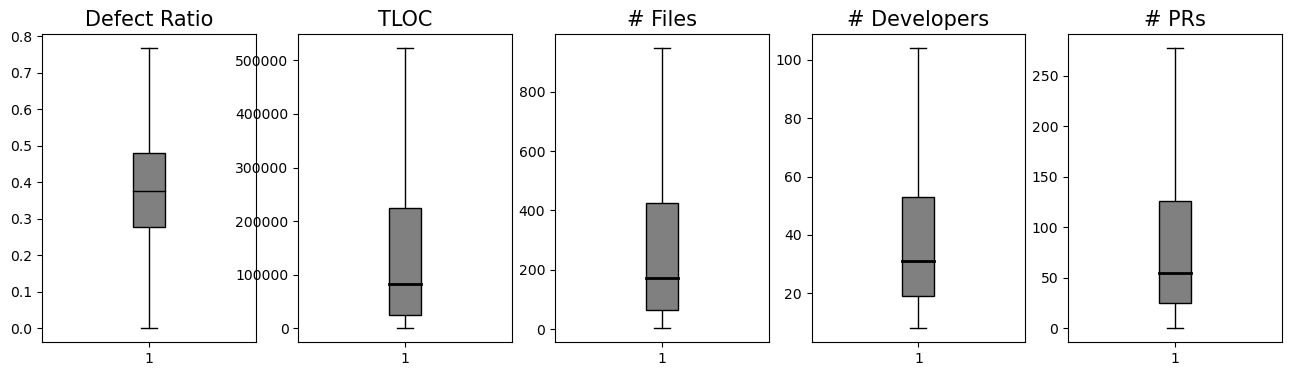

In [98]:
fig = plt.figure(num=None, figsize = (16,4), facecolor='w', edgecolor='k')

ax = fig.add_subplot(151)
bplot1 = ax.boxplot(bug_ratio,patch_artist = True,showfliers=False)
ax.set_title('Defect Ratio',size = 15)

#colors = [(0/255,193/255,195/255)]
colors = [(128/255,128/255,128/255)]
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot1['medians']:
    median.set(color='black', linewidth=1)


ax = fig.add_subplot(152)
bplot1 = ax.boxplot(locs,patch_artist = True,showfliers=False)
ax.set_title('TLOC',size = 15)

colors = [(128/255,128/255,128/255)]
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot1['medians']:
    median.set(color='black', linewidth=2)
    
ax = fig.add_subplot(153)
bplot1 = ax.boxplot(num_files,patch_artist = True,showfliers=False)
ax.set_title('# Files',size = 15)

colors = [(128/255,128/255,128/255)]
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot1['medians']:
    median.set(color='black', linewidth=2)
    
ax = fig.add_subplot(154)
bplot1 = ax.boxplot(num_devs,patch_artist = True,showfliers=False)
ax.set_title('# Developers',size = 15)

colors = [(128/255,128/255,128/255)]
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot1['medians']:
    median.set(color='black', linewidth=2)
    
ax = fig.add_subplot(155)
bplot1 = ax.boxplot(num_pulls,patch_artist = True,showfliers=False)
ax.set_title('# PRs',size = 15)

colors = [(128/255,128/255,128/255)]
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot1['medians']:
    median.set(color='black', linewidth=2)


plt.show()
fig.savefig('meta.pdf',format='pdf')